# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from scipy.stats import rankdata

from sklearn.cluster import KMeans

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

#### Data Dictionary

In [2]:
# %load Data_Dictionary.md

#### Azdias Data Files

In [3]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [4]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

# Print first 5 observations of dataset
azdias.head(5)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [5]:
# Print feature types
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

In [6]:
# Summarize features
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [7]:
# 'Natural' missing data summary
natural_missing = azdias.isnull().sum()
natural_missing.sum()

4896838

In [8]:
# # Function to parse 'missing_or_unknown' column into a list of integers
def parse_missing(string):
    # remove '[' and ']' characters
    string = string.replace('[', '')
    string = string.replace(']', '')
    # split string using commas as separators
    string_list = string.split(',') 
    return string_list

feat_info['missing_or_unknown_parsed'] = feat_info['missing_or_unknown'].map(parse_missing)

In [9]:
## Convert missing values to NaNs

# funtion for replacing missing_or_uknown_parsed to np.nan
def convert_to_nan(value):
    # Convert floats to integers (need a try/except block because some values are already nans)
    try:
        if isinstance(value, float):
            value = int(value)
    except:
        pass
    if str(value) in missing_or_unknown:
        return np.nan
    return value

for i in range(len(feat_info)):
    att = feat_info.iloc[i]['attribute']
    missing_or_unknown = feat_info.iloc[i]['missing_or_unknown_parsed']
    azdias[att] = azdias[att].map(convert_to_nan)


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [10]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

total_missing = azdias.isnull().sum()

print('After converting missing values to NaN, there are a total of {} missing values.'.format(total_missing.sum()))


After converting missing values to NaN, there are a total of 8373929 missing values.


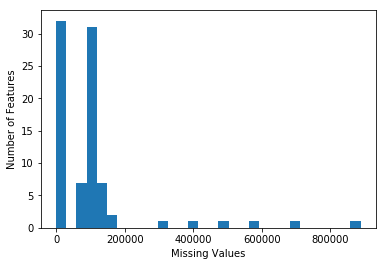

In [11]:
# Investigate patterns in the amount of missing data in each column.
plt.hist(total_missing, bins=30)
plt.xlabel('Missing Values')
plt.ylabel('Number of Features')
plt.show()

In [12]:
## Identify outliers visually from the preceding histogram.
#  Pick the attributes with > 200,000 missing values

outlier_threshold = 200000

# Outliers have missing values > outlier threshold
outlier_columns = list(total_missing[total_missing > outlier_threshold].index)
outlier_columns

['AGER_TYP',
 'GEBURTSJAHR',
 'TITEL_KZ',
 'ALTER_HH',
 'KK_KUNDENTYP',
 'KBA05_BAUMAX']

In [13]:
# Number of features with less than 20,000 missing values
len(total_missing[total_missing < 20000])

32

In [14]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

azdias = azdias.drop(outlier_columns, axis=1)
azdias.shape

(891221, 79)

In [15]:
azdias.isnull().sum()

ALTERSKATEGORIE_GROB       2881
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP               111196
LP_LEBENSPHASE_FEIN       97632
LP_LEBENSPHASE_GROB       94572
LP_FAMILIE_FEIN           77792
LP_FAMILIE_GROB           77792
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
SEMIO_ERL                     0
SEMIO_KULT                    0
                          ...  
MIN_GEBA

#### Discussion 1.1.2: Assess Missing Data in Each Column

There are two types of missing data in the data set: 'natural missing values' and 'known' missing values. The natural missing values show up as NaN values in the original dataset, whereas the known missing values are encoded in the `feat_info` data.

After replacing known missing values with NaNs, six features stand out as having outlier amounts of missing values:
- AGER_TYP
- GEBURTSJAHR
- TITEL_KZ
- ALTER_HH
- KK_KUNDENTYP
- KBA05_BAUMAX

After removing these outliers from the dataset, this leaves:
- Approximately 32 features with a small handful of missing values
- A cluster of features with around 100,000 missing values.

Considering the cluster of features with around 100,000 missing values, it is noticeable that several feautures have exactly the same number of missing values.

For example, `KBAO5_ANTG1`, `KBAO5_ANTG2`, `KBAO5_ANTG3`, `KBAO5_ANTG4`, and `KBAO5_GBI` all have 133,324 missing values.  Consulting the Data Dictionary markdown file, these features are all `RR3 micro-cell features`.  It seems likely that data for feature groupings like this was collected at the same time, hence explaining identical missing value numbers.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [16]:
# How much data is missing in each row of the dataset?

rows_missing = azdias.isnull().sum(axis=1)

rows_missing_mean = rows_missing.mean()
print(rows_missing_mean)

rows_missing_sd = rows_missing.std()
print(rows_missing_sd)

rows_missing_outliers = rows_missing_mean + 2.0 * rows_missing_sd
print(rows_missing_outliers)

5.64989379739
13.2346865382
32.1192668738


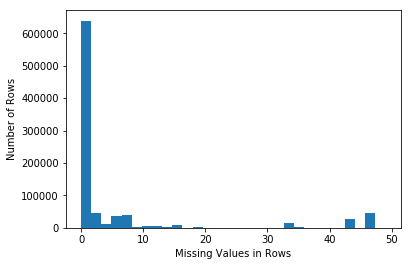

In [17]:
plt.hist(rows_missing, bins=30)
plt.xlabel('Missing Values in Rows')
plt.ylabel('Number of Rows')
plt.show();

In [18]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

rows_missing_less_than_threshold = azdias[azdias.isnull().sum(axis=1) <= rows_missing_outliers]
rows_missing_more_than_threshold = azdias[azdias.isnull().sum(axis=1) > rows_missing_outliers]

print(rows_missing_less_than_threshold.shape)
print('\n')
print(rows_missing_more_than_threshold.shape)

(798276, 79)


(92945, 79)


In [19]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

In [20]:
# Consider columns with less than 5000 rows of missing data

zero_missing = total_missing[total_missing < 5000]
zero_missing

ALTERSKATEGORIE_GROB     2881
ANREDE_KZ                   0
CJT_GESAMTTYP            4854
FINANZ_MINIMALIST           0
FINANZ_SPARER               0
FINANZ_VORSORGER            0
FINANZ_ANLEGER              0
FINANZ_UNAUFFAELLIGER       0
FINANZ_HAUSBAUER            0
FINANZTYP                   0
GFK_URLAUBERTYP          4854
GREEN_AVANTGARDE            0
LP_STATUS_FEIN           4854
LP_STATUS_GROB           4854
RETOURTYP_BK_S           4854
SEMIO_SOZ                   0
SEMIO_FAM                   0
SEMIO_REL                   0
SEMIO_MAT                   0
SEMIO_VERT                  0
SEMIO_LUST                  0
SEMIO_ERL                   0
SEMIO_KULT                  0
SEMIO_RAT                   0
SEMIO_KRIT                  0
SEMIO_DOM                   0
SEMIO_KAEM                  0
SEMIO_PFLICHT               0
SEMIO_TRADV                 0
ZABEOTYP                    0
ONLINE_AFFINITAET        4854
dtype: int64

#### Features to examine

These are some features that satisfiy all of the following conditions:

- Some of the rows have < 32 missing values
- Some of the rows have > 32 missing values
- The total amount of missing rows < 5000

For example:

`ALTERSKATEGORIE_GROB`, `ANREDE_KZ`, `CJT_GESAMTTYP`, `FINANZTYP`, `LP_STATUS_GROB`


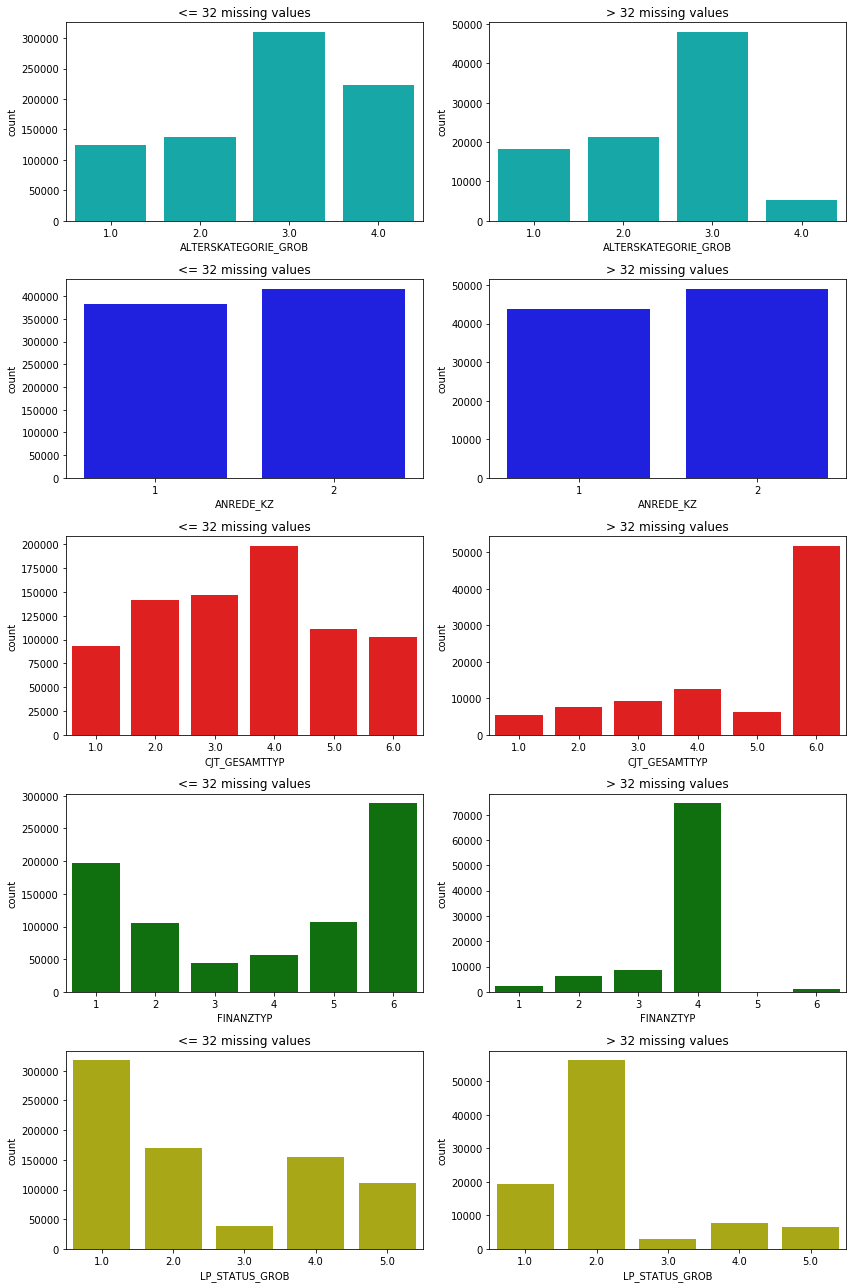

In [21]:
# This plot considers the five features in the preceding cell.
# The distribution for rows with > 32 missing values are plotted alongside the distribution for <= 32 missing rows

fig, ax = plt.subplots(5, 2, figsize=(12,18))

sns.countplot(ax=ax[0][0], color='c', x=rows_missing_less_than_threshold['ALTERSKATEGORIE_GROB']).set_title('<= 32 missing values')
sns.countplot(ax=ax[0][1], color='c', x=rows_missing_more_than_threshold['ALTERSKATEGORIE_GROB']).set_title('> 32 missing values')

sns.countplot(ax=ax[1][0], color='b', x=rows_missing_less_than_threshold['ANREDE_KZ']).set_title('<= 32 missing values')
sns.countplot(ax=ax[1][1], color='b', x=rows_missing_more_than_threshold['ANREDE_KZ']).set_title('> 32 missing values')

sns.countplot(ax=ax[2][0], color='r', x=rows_missing_less_than_threshold['CJT_GESAMTTYP']).set_title('<= 32 missing values')
sns.countplot(ax=ax[2][1], color='r', x=rows_missing_more_than_threshold['CJT_GESAMTTYP']).set_title('> 32 missing values')

sns.countplot(ax=ax[3][0], color='g', x=rows_missing_less_than_threshold['FINANZTYP']).set_title('<= 32 missing values')
sns.countplot(ax=ax[3][1], color='g', x=rows_missing_more_than_threshold['FINANZTYP']).set_title('> 32 missing values')

sns.countplot(ax=ax[4][0], color='y', x=rows_missing_less_than_threshold['LP_STATUS_GROB']).set_title('<= 32 missing values')
sns.countplot(ax=ax[4][1], color='y', x=rows_missing_more_than_threshold['LP_STATUS_GROB']).set_title('> 32 missing values')

fig.tight_layout()

plt.show()

#### Discussion 1.1.3: Assess Missing Data in Each Row

It does not look like there is sufficient evidence to reject the null hypothesis that the distributions in the two groups are qualitatively similar.  

Of the five atributes considered above, three of the attributes share broadly similar attributes (`ALTERSKATEGORIE_GROB`, `ANREDE_KZ` and `LP_STATUS_GROB`).  

The distributions for `CJT_GESAMTTYP` and `FINANZTYP` have a bit more concentration in their modal values, but otherwise are similar. 

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [22]:
# How many features are there of each data type?

print(feat_info.type.value_counts())

ordinal        49
categorical    21
mixed           7
numeric         7
interval        1
Name: type, dtype: int64


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [23]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

categorical = feat_info[feat_info.type == 'categorical']
categorical

,attribute,information_level,type,missing_or_unknown,missing_or_unknown_parsed
0,AGER_TYP,person,categorical,"[-1,0]","[-1, 0]"
2,ANREDE_KZ,person,categorical,"[-1,0]","[-1, 0]"
3,CJT_GESAMTTYP,person,categorical,[0],[0]
10,FINANZTYP,person,categorical,[-1],[-1]
12,GFK_URLAUBERTYP,person,categorical,[],[]
13,GREEN_AVANTGARDE,person,categorical,[],[]
17,LP_FAMILIE_FEIN,person,categorical,[0],[0]
18,LP_FAMILIE_GROB,person,categorical,[0],[0]
19,LP_STATUS_FEIN,person,categorical,[0],[0]
20,LP_STATUS_GROB,person,categorical,[0],[0]


In [24]:
# Collect the binary and multi-level attributes in separate lists
binary = []
multilevel = []

for i in range(len(categorical)):
    att = categorical.iloc[i]['attribute']
    if att not in outlier_columns:
        size = azdias[att].value_counts().size
        if size == 2:
            binary.append(att)
        else:
            multilevel.append(att)
            
print('Binary:', binary)
print('\n')
print('Multilevel:', multilevel)

Binary: ['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ']


Multilevel: ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


In [25]:
# Inspect binary attributes
for att in binary:
    categories = azdias[att].value_counts().index.tolist()
    print(att)
    print(categories)
    print(type(categories[0]), type(categories[1]))
    print('\n')

ANREDE_KZ
[2, 1]
<class 'int'> <class 'int'>


GREEN_AVANTGARDE
[0, 1]
<class 'int'> <class 'int'>


SOHO_KZ
[0.0, 1.0]
<class 'float'> <class 'float'>


VERS_TYP
[2.0, 1.0]
<class 'float'> <class 'float'>


OST_WEST_KZ
['W', 'O']
<class 'str'> <class 'str'>




In [26]:
# Re-encode `OST_WEST_KZ`

azdias['OST_WEST_KZ'].replace('W', 1, inplace=True)
azdias['OST_WEST_KZ'].replace('O', 2, inplace=True)

print(azdias['OST_WEST_KZ'].value_counts())

1.0    629528
2.0    168545
Name: OST_WEST_KZ, dtype: int64


In [27]:
# Drop the multilevel categorical variables from the dataframe
azdias = azdias.drop(multilevel, axis=1)
azdias.shape

(891221, 66)

#### Discussion 1.2.1: Re-Encode Categorical Features

I have kept the binary categorical features and dropped the multilevel categorical features. This is with a view to keeping the dimensionality of the feature set at a reasonable size.  14 multilevel categorical features have been dropped.  Performing one-hot encoding on those features would have significantly added to the size of the feature space.  As unsupervised learning methods can suffer from the *curse of dimensionality*, this seems a sensible strategy in the first instance.

Of the 5 binary features, four are already encoded as floats or ints, so do not need to be rengineered.

The `OST_WEST_KZ` variable has been re-encoded from strings ('W' and 'O') to integers 1 and 2.



#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [28]:
# Collect mixed attributes
type_mixed = feat_info[feat_info.type == 'mixed']

mixed = []
for i in range(len(type_mixed)):
    att = type_mixed.iloc[i]['attribute']
    if att not in outlier_columns:
        mixed.append(att)
mixed

['LP_LEBENSPHASE_FEIN',
 'LP_LEBENSPHASE_GROB',
 'PRAEGENDE_JUGENDJAHRE',
 'WOHNLAGE',
 'CAMEO_INTL_2015',
 'PLZ8_BAUMAX']

In [29]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

# Reproduced from Data Dictionary 

### 1.18. PRAEGENDE_JUGENDJAHRE
# Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
# - -1: unknown
# -  0: unknown
# -  1: 40s - war years (Mainstream, E+W)
# -  2: 40s - reconstruction years (Avantgarde, E+W)
# -  3: 50s - economic miracle (Mainstream, E+W)
# -  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
# -  5: 60s - economic miracle (Mainstream, E+W)
# -  6: 60s - generation 68 / student protestors (Avantgarde, W)
# -  7: 60s - opponents to the building of the Wall (Avantgarde, E)
# -  8: 70s - family orientation (Mainstream, E+W)
# -  9: 70s - peace movement (Avantgarde, E+W)
# - 10: 80s - Generation Golf (Mainstream, W)
# - 11: 80s - ecological awareness (Avantgarde, W)
# - 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
# - 13: 80s - Swords into ploughshares (Avantgarde, E)
# - 14: 90s - digital media kids (Mainstream, E+W)
# - 15: 90s - ecological awareness (Avantgarde, E+W)

# Need to re-encode PRAEGENDE_JUGENDJAHRE as:

# New interval variable 'Decade'
# [1, 2] -> 1
# [3, 4] -> 2
# [5, 6, 7] -> 3
# [8, 9] -> 4
# [10, 11, 12, 13, 14, 15] -> 5

# New binary variable 'Movement'
# 'Avantgarde' = 1
# 'Mainstream' = 2
# [2, 4, 6, 7, 9, 11, 13, 15] -> 1
# [1, 3, 5, 8, 10, 12, 14] -> 2

In [30]:
# Re-encode "PRAEGENDE_JUGENDJAHRE"

azdias['Decade'] = azdias['PRAEGENDE_JUGENDJAHRE']
azdias['Decade'].replace(1, 1, inplace=True)
azdias['Decade'].replace(2, 1, inplace=True)
azdias['Decade'].replace(3, 2, inplace=True)
azdias['Decade'].replace(4, 2, inplace=True)
azdias['Decade'].replace(5, 3, inplace=True)
azdias['Decade'].replace(6, 3, inplace=True)
azdias['Decade'].replace(7, 3, inplace=True)
azdias['Decade'].replace(8, 4, inplace=True)
azdias['Decade'].replace(9, 4, inplace=True)
azdias['Decade'].replace(10, 5, inplace=True)
azdias['Decade'].replace(11, 5, inplace=True)
azdias['Decade'].replace(12, 5, inplace=True)
azdias['Decade'].replace(13, 5, inplace=True)
azdias['Decade'].replace(14, 5, inplace=True)
azdias['Decade'].replace(15, 5, inplace=True)

print(azdias['Decade'].value_counts())

5.0    383014
4.0    179558
3.0    116078
2.0     75646
1.0     28761
Name: Decade, dtype: int64


In [31]:
# Re-encode "PRAEGENDE_JUGENDJAHRE": Part 2

azdias['Movement'] = azdias['PRAEGENDE_JUGENDJAHRE']
azdias['Movement'].replace(1, 2, inplace=True)
azdias['Movement'].replace(2, 1, inplace=True)
azdias['Movement'].replace(3, 2, inplace=True)
azdias['Movement'].replace(4, 1, inplace=True)
azdias['Movement'].replace(5, 2, inplace=True)
azdias['Movement'].replace(6, 1, inplace=True)
azdias['Movement'].replace(7, 1, inplace=True)
azdias['Movement'].replace(8, 2, inplace=True)
azdias['Movement'].replace(9, 1, inplace=True)
azdias['Movement'].replace(10, 2, inplace=True)
azdias['Movement'].replace(11, 1, inplace=True)
azdias['Movement'].replace(12, 2, inplace=True)
azdias['Movement'].replace(13, 1, inplace=True)
azdias['Movement'].replace(14, 2, inplace=True)
azdias['Movement'].replace(15, 1, inplace=True)

print(azdias['Movement'].value_counts())

2.0    586550
1.0    196507
Name: Movement, dtype: int64


In [32]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

# Reproduced from Data Dictionary 

### 4.3. CAMEO_INTL_2015
# German CAMEO: Wealth / Life Stage Typology, mapped to international code
# - -1: unknown
# - 11: Wealthy Households - Pre-Family Couples & Singles
# - 12: Wealthy Households - Young Couples With Children
# - 13: Wealthy Households - Families With School Age Children
# - 14: Wealthy Households - Older Families &  Mature Couples
# - 15: Wealthy Households - Elders In Retirement
# - 21: Prosperous Households - Pre-Family Couples & Singles
# - 22: Prosperous Households - Young Couples With Children
# - 23: Prosperous Households - Families With School Age Children
# - 24: Prosperous Households - Older Families & Mature Couples
# - 25: Prosperous Households - Elders In Retirement
# - 31: Comfortable Households - Pre-Family Couples & Singles
# - 32: Comfortable Households - Young Couples With Children
# - 33: Comfortable Households - Families With School Age Children
# - 34: Comfortable Households - Older Families & Mature Couples
# - 35: Comfortable Households - Elders In Retirement
# - 41: Less Affluent Households - Pre-Family Couples & Singles
# - 42: Less Affluent Households - Young Couples With Children
# - 43: Less Affluent Households - Families With School Age Children
# - 44: Less Affluent Households - Older Families & Mature Couples
# - 45: Less Affluent Households - Elders In Retirement
# - 51: Poorer Households - Pre-Family Couples & Singles
# - 52: Poorer Households - Young Couples With Children
# - 53: Poorer Households - Families With School Age Children
# - 54: Poorer Households - Older Families & Mature Couples
# - 55: Poorer Households - Elders In Retirement
# - XX: unknown

# Need to re-encode CAMEO_INTL_2015 as:

# New interval variable 'Wealth'
# [11, 12, 13, 14, 15] -> 1
# [21, 22, 23, 24, 25] -> 2
# [31, 32, 33, 34, 35] -> 3
# [41, 42, 43, 44, 45] -> 4
# [51, 52, 53, 54, 55] -> 5

# New binary variable 'Life_Stage'
# [11, 21, 31, 41, 51] -> 1
# [12, 22, 32, 42, 52] -> 2
# [13, 23, 33, 43, 53] -> 3
# [14, 24, 34, 44, 54] -> 4
# [15, 25, 35, 45, 55] -> 5

In [33]:
# Re-encode "CAMEO_INTL_2015"

azdias['Wealth'] = azdias['CAMEO_INTL_2015']
azdias['Wealth'].replace(11, 1, inplace=True)
azdias['Wealth'].replace(12, 1, inplace=True)
azdias['Wealth'].replace(13, 1, inplace=True)
azdias['Wealth'].replace(14, 1, inplace=True)
azdias['Wealth'].replace(15, 1, inplace=True)
azdias['Wealth'].replace(21, 2, inplace=True)
azdias['Wealth'].replace(22, 2, inplace=True)
azdias['Wealth'].replace(23, 2, inplace=True)
azdias['Wealth'].replace(24, 2, inplace=True)
azdias['Wealth'].replace(25, 2, inplace=True)
azdias['Wealth'].replace(31, 3, inplace=True)
azdias['Wealth'].replace(32, 3, inplace=True)
azdias['Wealth'].replace(33, 3, inplace=True)
azdias['Wealth'].replace(34, 3, inplace=True)
azdias['Wealth'].replace(35, 3, inplace=True)
azdias['Wealth'].replace(41, 4, inplace=True)
azdias['Wealth'].replace(42, 4, inplace=True)
azdias['Wealth'].replace(43, 4, inplace=True)
azdias['Wealth'].replace(44, 4, inplace=True)
azdias['Wealth'].replace(45, 4, inplace=True)
azdias['Wealth'].replace(51, 5, inplace=True)
azdias['Wealth'].replace(52, 5, inplace=True)
azdias['Wealth'].replace(53, 5, inplace=True)
azdias['Wealth'].replace(54, 5, inplace=True)
azdias['Wealth'].replace(55, 5, inplace=True)

print(azdias['Wealth'].value_counts())

51    133694
41     92336
24     91158
14     62884
43     56672
54     45391
25     39628
22     33155
23     26750
13     26336
45     26132
55     23955
52     20542
31     19024
34     18524
15     16974
44     14820
12     13249
35     10356
32     10354
33      9935
Name: Wealth, dtype: int64


In [34]:
# Re-encode "CAMEO_INTL_2015": Part 2

azdias['Life_Stage'] = azdias['CAMEO_INTL_2015']
azdias['Life_Stage'].replace(11, 1, inplace=True)
azdias['Life_Stage'].replace(12, 2, inplace=True)
azdias['Life_Stage'].replace(13, 3, inplace=True)
azdias['Life_Stage'].replace(14, 4, inplace=True)
azdias['Life_Stage'].replace(15, 5, inplace=True)
azdias['Life_Stage'].replace(21, 1, inplace=True)
azdias['Life_Stage'].replace(22, 2, inplace=True)
azdias['Life_Stage'].replace(23, 3, inplace=True)
azdias['Life_Stage'].replace(24, 4, inplace=True)
azdias['Life_Stage'].replace(25, 5, inplace=True)
azdias['Life_Stage'].replace(31, 1, inplace=True)
azdias['Life_Stage'].replace(32, 2, inplace=True)
azdias['Life_Stage'].replace(33, 3, inplace=True)
azdias['Life_Stage'].replace(34, 4, inplace=True)
azdias['Life_Stage'].replace(35, 5, inplace=True)
azdias['Life_Stage'].replace(41, 1, inplace=True)
azdias['Life_Stage'].replace(42, 2, inplace=True)
azdias['Life_Stage'].replace(43, 3, inplace=True)
azdias['Life_Stage'].replace(44, 4, inplace=True)
azdias['Life_Stage'].replace(45, 5, inplace=True)
azdias['Life_Stage'].replace(51, 1, inplace=True)
azdias['Life_Stage'].replace(52, 2, inplace=True)
azdias['Life_Stage'].replace(53, 3, inplace=True)
azdias['Life_Stage'].replace(54, 4, inplace=True)
azdias['Life_Stage'].replace(55, 5, inplace=True)

print(azdias['Life_Stage'].value_counts())

51    133694
41     92336
24     91158
14     62884
43     56672
54     45391
25     39628
22     33155
23     26750
13     26336
45     26132
55     23955
52     20542
31     19024
34     18524
15     16974
44     14820
12     13249
35     10356
32     10354
33      9935
Name: Life_Stage, dtype: int64


#### Discussion 1.2.2: Engineer Mixed-Type Features

These are the mixed-type features:

`LP_LEBENSPHASE_FEIN`, `LP_LEBENSPHASE_GROB`, `PRAEGENDE_JUGENDJAHRE`, `WOHNLAGE`, `CAMEO_INTL_2015`, `KBA05_BAUMAX`, `PLZ8_BAUMAX`

`PRAEGENDE_JUGENDJAHRE` has been re-encoded as two new attributes: `Decade` and `Movement`.

`CAMEO_INTL_2015` has been re-encoded as two new attributes: `Wealth` and `Life_Stage`.

`LP_LEBENSPHASE_FEIN` has 40 possible values in fine detail. As `LP_LEBENSPHASE_GROB` is a coarse grouping of the same information (with 12 possible values), I will drop the `LP_LEBENSPHASE_FEIN` attribute.

The other attributes have been kept as they are.  

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [35]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

# Subset the new re-engineered attributes to include only those rows with fewer missing values than the `rows_missing_outliers` 
# threshold

azdias = azdias[azdias.isnull().sum(axis=1) <= rows_missing_outliers]
azdias.shape

(801246, 70)

In [36]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

# Drop 'PRAEGENDE_JUGENDJAHRE' variable
azdias = azdias.drop('PRAEGENDE_JUGENDJAHRE', axis=1)

# Drop 'CAMEO_INTL_2015' variable
azdias = azdias.drop('CAMEO_INTL_2015', axis=1)

# Drop 'LP_LEBENSPHASE_FEIN' variable
azdias = azdias.drop('LP_LEBENSPHASE_FEIN', axis=1)

azdias.shape

(801246, 67)

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [37]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...

    # funtion for replacing missing_or_uknown_parsed to np.nan
    def convert_to_nan(value):
        if str(value) in missing_or_unknown:
            return np.nan
        return value

    for i in range(len(feat_info)):
        att = feat_info.iloc[i]['attribute']
        missing_or_unknown = feat_info.iloc[i]['missing_or_unknown_parsed']
        df[att] = df[att].map(convert_to_nan)
        
    # remove selected columns and rows, ...

    # Remove the outlier columns from the dataset. 
    df = df.drop(outlier_columns, axis=1)
    
    # Remove the outlier rows from the dataset
    df = df[df.isnull().sum(axis=1) <= rows_missing_outliers]
        
    # select, re-encode, and engineer column values.
    
    # drop multilevel attributes
    # Drop the multilevel categorical variables from the dataframe
    df = df.drop(multilevel, axis=1)
    
    # Re-encode "OST_WEST_KZ"
    df['OST_WEST_KZ'].replace('W', 1, inplace=True)
    df['OST_WEST_KZ'].replace('O', 2, inplace=True)
    
    # Re-encode "PRAEGENDE_JUGENDJAHRE"
    df['Decade'] = df['PRAEGENDE_JUGENDJAHRE']
    df['Decade'].replace(1, 1, inplace=True)
    df['Decade'].replace(2, 1, inplace=True)
    df['Decade'].replace(3, 2, inplace=True)
    df['Decade'].replace(4, 2, inplace=True)
    df['Decade'].replace(5, 3, inplace=True)
    df['Decade'].replace(6, 3, inplace=True)
    df['Decade'].replace(7, 3, inplace=True)
    df['Decade'].replace(8, 4, inplace=True)
    df['Decade'].replace(9, 4, inplace=True)
    df['Decade'].replace(10, 5, inplace=True)
    df['Decade'].replace(11, 5, inplace=True)
    df['Decade'].replace(12, 5, inplace=True)
    df['Decade'].replace(13, 5, inplace=True)
    df['Decade'].replace(14, 5, inplace=True)
    df['Decade'].replace(15, 5, inplace=True)
    
    # Re-encode "PRAEGENDE_JUGENDJAHRE": Part 2
    df['Movement'] = df['PRAEGENDE_JUGENDJAHRE']
    df['Movement'].replace(1, 2, inplace=True)
    df['Movement'].replace(2, 1, inplace=True)
    df['Movement'].replace(3, 2, inplace=True)
    df['Movement'].replace(4, 1, inplace=True)
    df['Movement'].replace(5, 2, inplace=True)
    df['Movement'].replace(6, 1, inplace=True)
    df['Movement'].replace(7, 1, inplace=True)
    df['Movement'].replace(8, 2, inplace=True)
    df['Movement'].replace(9, 1, inplace=True)
    df['Movement'].replace(10, 2, inplace=True)
    df['Movement'].replace(11, 1, inplace=True)
    df['Movement'].replace(12, 2, inplace=True)
    df['Movement'].replace(13, 1, inplace=True)
    df['Movement'].replace(14, 2, inplace=True)
    df['Movement'].replace(15, 1, inplace=True)
    
    # Re-encode "CAMEO_INTL_2015"
    df['Wealth'] = df['CAMEO_INTL_2015']
    df['Wealth'].replace(11, 1, inplace=True)
    df['Wealth'].replace(12, 1, inplace=True)
    df['Wealth'].replace(13, 1, inplace=True)
    df['Wealth'].replace(14, 1, inplace=True)
    df['Wealth'].replace(15, 1, inplace=True)
    df['Wealth'].replace(21, 2, inplace=True)
    df['Wealth'].replace(22, 2, inplace=True)
    df['Wealth'].replace(23, 2, inplace=True)
    df['Wealth'].replace(24, 2, inplace=True)
    df['Wealth'].replace(25, 2, inplace=True)
    df['Wealth'].replace(31, 3, inplace=True)
    df['Wealth'].replace(32, 3, inplace=True)
    df['Wealth'].replace(33, 3, inplace=True)
    df['Wealth'].replace(34, 3, inplace=True)
    df['Wealth'].replace(35, 3, inplace=True)
    df['Wealth'].replace(41, 4, inplace=True)
    df['Wealth'].replace(42, 4, inplace=True)
    df['Wealth'].replace(43, 4, inplace=True)
    df['Wealth'].replace(44, 4, inplace=True)
    df['Wealth'].replace(45, 4, inplace=True)
    df['Wealth'].replace(51, 5, inplace=True)
    df['Wealth'].replace(52, 5, inplace=True)
    df['Wealth'].replace(53, 5, inplace=True)
    df['Wealth'].replace(54, 5, inplace=True)
    df['Wealth'].replace(55, 5, inplace=True)
    
    # Re-encode "CAMEO_INTL_2015": Part 2
    df['Life_Stage'] = df['CAMEO_INTL_2015']
    df['Life_Stage'].replace(11, 1, inplace=True)
    df['Life_Stage'].replace(12, 2, inplace=True)
    df['Life_Stage'].replace(13, 3, inplace=True)
    df['Life_Stage'].replace(14, 4, inplace=True)
    df['Life_Stage'].replace(15, 5, inplace=True)
    df['Life_Stage'].replace(21, 1, inplace=True)
    df['Life_Stage'].replace(22, 2, inplace=True)
    df['Life_Stage'].replace(23, 3, inplace=True)
    df['Life_Stage'].replace(24, 4, inplace=True)
    df['Life_Stage'].replace(25, 5, inplace=True)
    df['Life_Stage'].replace(31, 1, inplace=True)
    df['Life_Stage'].replace(32, 2, inplace=True)
    df['Life_Stage'].replace(33, 3, inplace=True)
    df['Life_Stage'].replace(34, 4, inplace=True)
    df['Life_Stage'].replace(35, 5, inplace=True)
    df['Life_Stage'].replace(41, 1, inplace=True)
    df['Life_Stage'].replace(42, 2, inplace=True)
    df['Life_Stage'].replace(43, 3, inplace=True)
    df['Life_Stage'].replace(44, 4, inplace=True)
    df['Life_Stage'].replace(45, 5, inplace=True)
    df['Life_Stage'].replace(51, 1, inplace=True)
    df['Life_Stage'].replace(52, 2, inplace=True)
    df['Life_Stage'].replace(53, 3, inplace=True)
    df['Life_Stage'].replace(54, 4, inplace=True)
    df['Life_Stage'].replace(55, 5, inplace=True)

    # Drop 'PRAEGENDE_JUGENDJAHRE' variable
    df = df.drop('PRAEGENDE_JUGENDJAHRE', axis=1)

    # Drop 'CAMEO_INTL_2015' variable
    df = df.drop('CAMEO_INTL_2015', axis=1)
    
    # Drop 'LP_LEBENSPHASE_FEIN' variable
    df = df.drop('LP_LEBENSPHASE_FEIN', axis=1)
    
    # Return the cleaned dataframe.
    return df
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [38]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

original = azdias.shape[0]
print('Current number of dataset rows is:', original)

new = azdias.dropna().shape[0]
print('\n')
print('If we were to simply drop nas, the new number of dataset rows would be:', new)

retained = 100 * new / original
print('\n')
print('i.e. we would retain {:.0f}% of the rows'.format(retained))

Current number of dataset rows is: 801246


If we were to simply drop nas, the new number of dataset rows would be: 623210


i.e. we would retain 78% of the rows


In [39]:
# Given the high percentage of retained rows, use the simple approach of dropping nas
azdias = azdias.dropna()

In [40]:
# Apply feature scaling to the general population demographics data.

ss = StandardScaler()
azdias_scaled = pd.DataFrame(ss.fit_transform(azdias), columns=azdias.columns)

In [41]:
azdias_scaled.describe()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,Decade,Movement,Wealth,Life_Stage
count,6.232100e+05,6.232100e+05,6.232100e+05,6.232100e+05,6.232100e+05,6.232100e+05,6.232100e+05,6.232100e+05,6.232100e+05,6.232100e+05,...,6.232100e+05,6.232100e+05,6.232100e+05,6.232100e+05,6.232100e+05,6.232100e+05,6.232100e+05,6.232100e+05,6.232100e+05,6.232100e+05
mean,-2.547629e-16,1.443794e-16,-1.123659e-16,6.772394e-18,-2.670193e-17,-2.234520e-17,-1.260418e-17,-8.202692e-17,1.928536e-17,7.598136e-17,...,1.400654e-17,1.236475e-17,2.048763e-16,3.436363e-17,6.229406e-17,-8.774469e-17,2.611932e-16,1.739502e-16,1.726961e-16,1.726961e-16
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,...,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,-1.746285e+00,-1.022680e+00,-1.512225e+00,-1.141399e+00,-1.765053e+00,-1.221854e+00,-1.139028e+00,-1.588888e+00,-5.536696e-01,-1.591640e+00,...,-6.673367e-01,-2.721004e+00,-2.111169e+00,-2.223025e+00,-1.914219e+00,-1.563998e+00,-2.607816e+00,-1.691142e+00,-1.733026e+00,-1.733026e+00
25%,-7.720877e-01,-1.022680e+00,-7.773488e-01,-1.141399e+00,-1.045044e+00,-1.221854e+00,-1.139028e+00,-8.565452e-01,-5.536696e-01,-2.734974e-01,...,-6.673367e-01,-6.397014e-01,-3.147649e-01,-2.011789e-01,-6.074378e-01,-8.238443e-01,-8.829520e-01,-1.691142e+00,-8.716029e-01,-8.716029e-01
50%,2.021099e-01,9.778232e-01,-4.247284e-02,2.198300e-01,3.949737e-01,1.586027e-01,-4.103271e-01,-1.242025e-01,-5.536696e-01,-2.734974e-01,...,-6.673367e-01,-6.397014e-01,-3.147649e-01,-2.011789e-01,-1.718442e-01,-8.369108e-02,-2.051980e-02,5.913164e-01,3.487473e-01,3.487473e-01
75%,1.176308e+00,9.778232e-01,6.924032e-01,9.004447e-01,1.114982e+00,8.488311e-01,1.047074e+00,6.081403e-01,-5.536696e-01,1.044645e+00,...,6.868231e-01,4.009499e-01,5.834372e-01,8.097443e-01,6.993429e-01,6.564622e-01,8.419124e-01,5.913164e-01,1.066600e+00,1.066600e+00
max,1.176308e+00,9.778232e-01,1.427279e+00,1.581059e+00,1.114982e+00,1.539060e+00,1.775775e+00,1.340483e+00,1.806131e+00,1.044645e+00,...,2.040983e+00,1.441601e+00,1.481639e+00,1.820667e+00,1.570530e+00,1.396615e+00,8.419124e-01,5.913164e-01,1.353741e+00,1.353741e+00


### Discussion 2.1: Apply Feature Scaling

The simple approach of dropping nas from the dataset results in a reduction in the dataset rows from 801,246 to 623,210.  In other words, 78% of the rows are retained.

The tradeoff between dropping nas or imputing values is loss of data versus potentially introducing bias into the dataset. Given the reasonably high retention from dropping nas, I have gone for the simpler approach of dropping nas.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [42]:
# Apply PCA to the data.

pca = PCA()
pca.fit_transform(azdias_scaled);

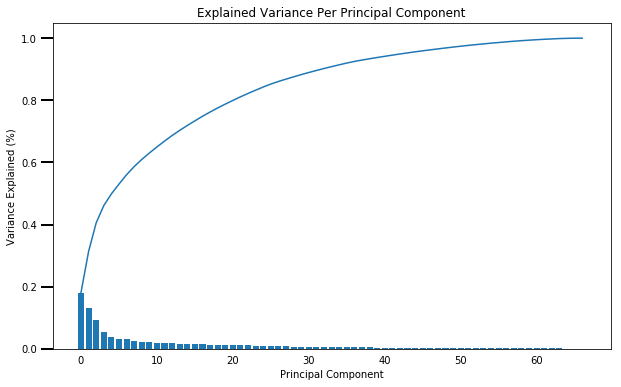

In [43]:
# # Investigate the variance accounted for by each principal component.

def scree_plot(pca):
    """
    Creates a scree plot of the principal components
    
    INPUT: pca - an instantiation of sklearn.decomposition.PCA
    
    OUTPUT: None
    """
    num_components = len(pca.explained_variance_ratio_)
    inds = np.arange(num_components)
    vals = pca.explained_variance_ratio_
    
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(inds, vals)
    ax.plot(inds, cumvals)
        
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
    
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title("Explained Variance Per Principal Component")
    
scree_plot(pca)

In [44]:
# Determine the number of components that achieves 80% explained variance.
n_components = 2
explained_variance = 0
while explained_variance < 0.80:
    pca = PCA(n_components=n_components)
    pca.fit_transform(azdias_scaled)
    explained_variance = pca.explained_variance_ratio_.sum()
    print('Number of components:', n_components, ', Explained Variance:', explained_variance)
    n_components += 1

Number of components: 2 , Explained Variance: 0.312992888121
Number of components: 3 , Explained Variance: 0.40531951632
Number of components: 4 , Explained Variance: 0.460928348091
Number of components: 5 , Explained Variance: 0.498555176374
Number of components: 6 , Explained Variance: 0.530078734444
Number of components: 7 , Explained Variance: 0.560232141472
Number of components: 8 , Explained Variance: 0.586325124755
Number of components: 9 , Explained Variance: 0.609333051966
Number of components: 10 , Explained Variance: 0.630117815484
Number of components: 11 , Explained Variance: 0.649771496881
Number of components: 12 , Explained Variance: 0.668381822402
Number of components: 13 , Explained Variance: 0.68630497683
Number of components: 14 , Explained Variance: 0.702825657042
Number of components: 15 , Explained Variance: 0.718718677244
Number of components: 16 , Explained Variance: 0.733414549215
Number of components: 17 , Explained Variance: 0.748367132848
Number of componen

In [45]:
# Re-apply PCA to the data while selecting for number of components to retain.

pca = PCA(n_components=22)
azdias_scaled_pca = pca.fit_transform(azdias_scaled)

### Discussion 2.2: Perform Dimensionality Reduction

Examining the scree plot shows that at around 80% of explained variance the incremental explained variance achieved by adding more components starts to markedly decline.  Therefore, 80% appears to be a sensible ratio that achieves a good degree of dimensionality reduction, while still explaining a good proportion of the variability in the data.

The dimensionality reduction achieved is 67 attributes being reduced to 22 principal components.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [46]:
def highest_and_lowest(component):
    '''
    INPUTS: principal_components - components returned by fitting PCA instance to scaled dataset
            component_index - the index of the component to be examined
    '''
    inds = rankdata(component)

    largest = np.argmax(inds)
    smallest = np.argmin(inds)

    return azdias_scaled.columns[largest], azdias_scaled.columns[smallest]

In [47]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

i = 0

first_component_largest, first_component_smallest = highest_and_lowest(pca.components_[i])

print("Most Positive Attribute:", first_component_largest,
      ", Size:", np.max(pca.components_[i]))
print("Most Negative Attribute:", first_component_smallest,
       ", Size:", np.min(pca.components_[i]))

Most Positive Attribute: PLZ8_ANTG3 , Size: 0.219994002689
Most Negative Attribute: MOBI_REGIO , Size: -0.234795124939


The interpretation of a high positive weight on `PLZ8_ANTG3` is a high number of 6-10 family homes.

The interpretation of a high negative weight on `MOBI_REGIO` is a negative weight on very little regional mobility, which can overall be interpreted as high regional mobility.

To summarize, the first principal component represents:

- a macro-cell with a high number of 6-10 family numbers
- a region with mobility

In [48]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

i = 1

second_component_largest, second_component_smallest = highest_and_lowest(pca.components_[i])

print("Most Positive Attribute:", second_component_largest,
      ", Size:", np.max(pca.components_[i]))
print("Most Negative Attribute:", second_component_smallest,
       ", Size:", np.min(pca.components_[i]))

Most Positive Attribute: ALTERSKATEGORIE_GROB , Size: 0.26755004041
Most Negative Attribute: SEMIO_REL , Size: -0.270029728163


The interpretation of a high positive weight on `ALTERSKATEGORIE_GROB` is estimated age based on name analysis.

The interpretation of a high negative weight on `SEMIO_REL` is a negative weight on religious personality type, which can overall be interpreted as 'not religious'.

To summarize, the second principal component represents:

- older age
- not religious

In [49]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

i = 2

third_component_largest, third_component_smallest = highest_and_lowest(pca.components_[i])

print("Most Positive Attribute:", third_component_largest,
      ", Size:", np.max(pca.components_[i]))
print("Most Negative Attribute:lest Component:", third_component_smallest,
       ", Size:", np.min(pca.components_[i]))

Most Positive Attribute: SEMIO_VERT , Size: 0.349432777032
Most Negative Attribute:lest Component: ANREDE_KZ , Size: -0.367962007491


The interpretation of a high positive weight on `SEMIO_VERT` is 'dreamful' personality type, but since a higher score represents lower affinity to this personality type, the overall conclusion is 'not dreamful' personality type.

The interpretation of a high negative weight on `ANREDE_KZ` is a negative weight on gender type being female, which can overall be interpreted as gender type being male.

To summarize, the third principal component represents:

- 'not dreamful' personality type
- gender type male

### Discussion 2.3: Interpret Principal Components


I have chosen to focus on the largest positive weight and largest negative weight for each principal component.

As long as we consider the largest weights of the principal components in this manner, they offer an effective way to identify segments of the population. 

The first principal component may be summarized as:
- a macro-cell with a high number of 6-10 family numbers
- a region with mobility

The second principal component may be summarized as:
- older age
- not religious

The third principal component may be summarized as:
- 'not dreamful' personality type
- gender type male

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [51]:
# Over a number of different cluster counts...
centers = []
scores = []
for k in range(1, 13): 
    centers.append(k)
    # run k-means clustering on the data and...
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(azdias_scaled_pca)
    # compute the average within-cluster distances.
    score = kmeans.score(azdias_scaled_pca)
    print(k, -score/1000000.0)
    scores.append(-score/1000000.0)   

1 33.8568917316
2 28.1528027791
3 25.4892154683
4 23.7906292646
5 22.6406327645
6 21.6230862709
7 20.7141991449
8 20.0979067126
9 19.5140554545
10 19.0325332026
11 18.4431943211
12 18.1964162483


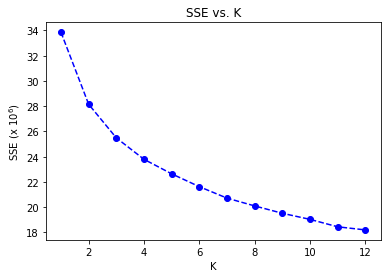

In [52]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE (x $10^6$)');
plt.title('SSE vs. K')
plt.show()

In [53]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

kmeans = KMeans(n_clusters=11, random_state=42)
kmeans.fit(azdias_scaled_pca)
general_preds = kmeans.predict(azdias_scaled_pca)

### Discussion 3.1: Apply Clustering to General Population

The reduction in the squared-error is smoother than in textbook examples of sharp elbow points.

Therefore, I employed [Granville's automated elbow point methodology](https://www.datasciencecentral.com/how-to-automatically-determine-the-number-of-clusters-in-your-dat/) to detect the first elbow point.

| No. clusters | SSE (millions) | Delta 1 | Delta 2 | Strength
| ----- | ----- | ----- | ----- | ----- |
| 1 | 33.86 
| 2 | 28.15 | 5.71 
| 3 | 25.49 | 2.66 | 3.05 | -0.74
| 4 | 23.79 | 1.70 | 0.96 | -0.60
| 5 | 22.64 | 1.15 | 0.55 | -0.89
| 6 | 21.62 | 1.02 | 0.13 | -0.80
| 7 | 20.71 | 0.91 | 0.11 | -0.31
| 8 | 20.10 | 0.61 | 0.30 | -0.57
| 9 | 19.51 | 0.59 | 0.02 | -0.37
| 10 | 19.03 | 0.48 | 0.11 | -0.70
| 11 | 18.44 | 0.59 | -0.11 | 0.11
| 12 | 18.20 | 0.24 | 0.35 | 



The `Strength` moves from negative to positive at `k=11` clusters, therefore `k=11` is identified as the elbow point in the data.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [54]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')

In [55]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

customers_cleaned = clean_data(customers).dropna()

# Re-use ss object from population dataset
customers_scaled = ss.transform(customers_cleaned)

# Re-use pca object from population dataset
customers_pca = pca.transform(customers_scaled)

# Re-use kmeans object from population dataset
customers_preds = kmeans.predict(customers_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [56]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

_, general_counts = np.unique(general_preds, return_counts=True)
general_proportions = general_counts / np.sum(general_counts)

_, customers_counts = np.unique(customers_preds, return_counts=True)
customers_proportions = customers_counts / np.sum(customers_counts)

differences = general_proportions - customers_proportions

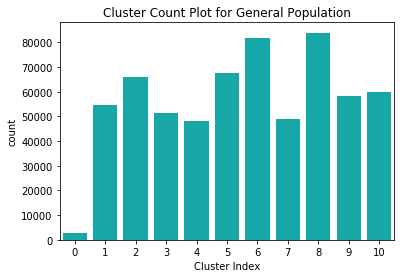

In [57]:
sns.countplot(general_preds, color='c')
plt.xlabel('Cluster Index')
plt.title('Cluster Count Plot for General Population')
plt.show();

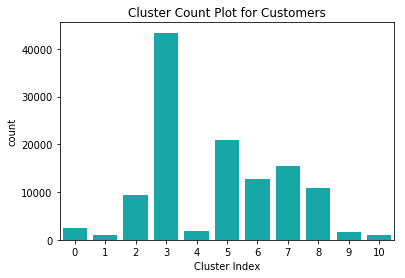

In [58]:
sns.countplot(customers_preds, color='c')
plt.xlabel('Cluster Index')
plt.title('Cluster Count Plot for Customers')
plt.show();

In [59]:
for idx, d in enumerate(differences):
    print("For Cluster Index {}, general population proportion - customer proportion = {:.4f}".format(idx, d))

For Cluster Index 0, general population proportion - customer proportion = -0.0169
For Cluster Index 1, general population proportion - customer proportion = 0.0785
For Cluster Index 2, general population proportion - customer proportion = 0.0279
For Cluster Index 3, general population proportion - customer proportion = -0.2765
For Cluster Index 4, general population proportion - customer proportion = 0.0617
For Cluster Index 5, general population proportion - customer proportion = -0.0646
For Cluster Index 6, general population proportion - customer proportion = 0.0253
For Cluster Index 7, general population proportion - customer proportion = -0.0485
For Cluster Index 8, general population proportion - customer proportion = 0.0447
For Cluster Index 9, general population proportion - customer proportion = 0.0804
For Cluster Index 10, general population proportion - customer proportion = 0.0880


The most overrepresented cluster in the customers data is the fourth cluster (index 3), in which the proportion in the customer data is a large 27.65% higher than in the general population.

The most underrepresented cluster in the customers data is the eleventh cluster (index 10), in which the proportion in the general population is 8.80% higher than in the customer data.

In [60]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

i = 3

centroid = kmeans.cluster_centers_[i]

print(centroid)

[-3.43824559  0.10843335  2.75313344  2.16497693  0.02090046 -0.12979161
 -0.17764207 -0.03876341  0.1836509  -0.29303074  0.02935082  0.03952878
 -0.11236405 -0.25970734 -0.29106844 -0.00765066  0.10817229  0.10387868
 -0.19235027 -0.19390962  0.15348119 -0.01969537]


In [61]:
# The centroid for the overrepresented cluster is an array of weights on the 23 principal components we found from the 
# population data.

# We can construct a latent factor from this centroid by computing the weighted sum of principal components:

latent_factor_over = np.zeros(azdias_scaled.shape[1])

for i in range(len(centroid)):
    latent_factor_over += centroid[i] * pca.components_[i]
    
latent_factor_over

array([ 0.49489985, -0.882262  ,  1.27838038, -0.7407726 ,  0.57668628,
       -0.92871345, -0.30656903, -0.8613812 ,  1.60576945, -0.18074979,
        0.59233136,  0.35849788,  0.57230058,  0.37668605, -0.10095418,
       -0.05469685,  1.00184969,  0.44985872, -0.23596603,  0.34806936,
       -0.71758115, -0.73073024, -0.64900901, -0.83979221, -0.47221831,
       -0.37186138,  0.00519147, -0.11020222,  0.45141886, -0.07667376,
       -1.35339355,  0.02407004,  0.32223759, -0.41750528, -0.08575064,
        0.25751205,  0.05796367, -0.31514394, -0.45453659,  0.89177972,
       -0.12735039, -0.53262857, -0.48983219,  0.7351051 , -0.07423494,
        0.00528575,  0.03269166,  0.25451238, -0.63924537,  0.84653992,
        0.2694792 , -0.59146957,  0.24782989,  0.57714389, -0.26319818,
       -0.45695715, -0.47151034, -0.51160584,  0.09949818,  0.51451667,
       -0.16973461,  0.0166385 , -0.11127108, -0.54257254, -1.60189157,
       -0.80168759, -0.80168759])

In [62]:
# Now use the function from section 2.3 to identify the largest positive and largest negative weights in the latent factor
# corresponding to the overrepresented group

first_component_largest, first_component_smallest = highest_and_lowest(latent_factor_over)

print("Most Positive Attribute:", first_component_largest,
      ", Size:", np.max(latent_factor_over))
print("Most Negative Attribute:", first_component_smallest,
       ", Size:", np.min(latent_factor_over))

Most Positive Attribute: GREEN_AVANTGARDE , Size: 1.60576944783
Most Negative Attribute: Movement , Size: -1.60189157403


The interpretation of a high positive weight on `GREEN_AVANTGARDE` is membership in an environmental sustainability group as part of youth.

The interpretation of a high negative weight on `Movement` is a negative weight on the dominating movement in a person's youth being 'mainstream', which can overall be interpreted as the person' dominant movement during their youth being 'avantgarde'.

Overall, we see a consistent picture emerging for the kind of person in the overrepresented group:

- membership in an environmental sustainability group as part of their youth
- 'avantgarde' being their dominant movement of their youth

In [63]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

i = 10

centroid = kmeans.cluster_centers_[i]

print(centroid)

[  4.54313166e+00  -1.56917626e+00  -2.81681023e+00   4.61268080e-01
   1.53117655e-02   8.64241714e-03  -2.26774047e-01  -2.89050998e-01
   6.30067916e-01   5.53932549e-02  -2.02931188e-01  -1.01698263e-01
   3.90296749e-02  -2.21107524e-03  -2.03750280e-01   9.65447901e-03
  -1.43587402e-01   1.87436166e-01  -2.15881320e-02   1.13767270e-01
   3.47975771e-03  -4.51199633e-02]


In [64]:
# The centroid for the underrepresented cluster is an array of weights on the 23 principal components we found from the 
# population data.

# We can construct a latent factor from this centroid by computing the weighted sum of principal components:

latent_factor_under = np.zeros(azdias_scaled.shape[1])

for i in range(len(centroid)):
    latent_factor_under += centroid[i] * pca.components_[i]
    
latent_factor_under

array([ -1.26866246e+00,   1.03498797e+00,  -1.41196643e+00,
         1.04867422e+00,  -8.95264174e-01,   9.19964353e-01,
         7.57546427e-01,   7.95434117e-01,  -4.57737327e-01,
        -3.21507108e-02,  -4.02428965e-01,  -5.87329224e-01,
        -4.49862201e-01,  -8.06478589e-02,   8.00810257e-01,
         6.82910601e-01,  -1.08463869e+00,  -8.63262003e-01,
        -2.97355898e-01,   3.34787857e-02,   1.54641381e+00,
         5.81868732e-01,   9.19579245e-01,   1.04013021e+00,
         1.21755237e+00,   1.26458440e+00,   8.12451271e-03,
        -2.06758234e-01,  -2.15810245e-01,  -5.19026621e-02,
         7.62738272e-01,  -1.45787883e-01,  -4.11656626e-01,
         4.15209289e-01,   3.31686063e-02,  -5.86518516e-01,
        -8.95730091e-02,   1.81851372e-01,  -3.19476647e-01,
        -7.87194702e-01,   9.35218512e-04,   4.92386742e-01,
         5.26822037e-01,  -7.53541691e-01,  -4.17170816e-01,
         6.96583555e-01,  -5.62451772e-01,  -3.93837673e-01,
         1.70600635e-01,

In [65]:
# Now use the function from section 2.3 to identify the largest positive and largest negative weights in the latent factor
# corresponding to the underrepresented group

first_component_largest, first_component_smallest = highest_and_lowest(latent_factor_under)

print("Most Positive Attribute:", first_component_largest,
      ", Size:", np.max(latent_factor_under))
print("Most Negative Attribute:", first_component_smallest,
       ", Size:", np.min(latent_factor_under))

Most Positive Attribute: SEMIO_RAT , Size: 1.54641380799
Most Negative Attribute: FINANZ_MINIMALIST , Size: -1.41196643313


The interpretation of a high positive weight on `SEMIO_RAT` is 'rational' personality type, but since higher scores indicate lower affinity, the overall conclusion is 'not rational' personalty type.

The interpretation of a high negative weight on `FINANZ_MINIMALIST` is a negative weight on 'low financial interest.  But higher scores represent lower association with the type, so we have a negative weight on 'not low financial interest'.  Finally, as we have a negative weight, the overall interpretation is 'not not low financial interest', i.e. 'low financial interest'.

Overall, we see a consistent picture emerging for the kind of person in the underrepresented group:

- 'not rational' personality type
- low financial interest

### Discussion 3.3: Compare Customer Data to Demographics Data

The first step of the analysis is to use the cleaning function from Section 1.3 for the customers dataset.

Then the saved standard scaler, principal components and kmeans objects are used to identify the clusters for the customers dataset. Note that the fitting step occurs on the population set only.

In step 3, we identify the proportions of people in each cluster and identify the clusters in which people in the customers dataset are overrepresented and underrepresented.  The overepresentation in the most overrepresented cluster is more dramatic with a 27.7% higher proportion than in the general population, whereas the most underrepresented cluster has a smaller difference of 8.8%.

Step 3 suggests we are likely to draw more actionable insights from the overrepresented cluster.

In Step 4, we identify the centroids of the overrepresented and underrepresented clusters and convert these into latent factors by interpreting the centroids as weights to attach to the principal components identified in the population data.

Finally, we identify the highest positive and highest negative weights in the latent factors and map these to the descriptions given in the Data Dictionary.

Our overall conclusions are:

#### Kinds of people overrepresented in the customers data set
- membership in an environmental sustainability group as part of their youth
- 'avantgarde' being their dominant movement of their youth 

#### Kinds of people underrepresented in the customers data set
- 'not rational' personality type
- 'low financial interest'

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.